In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import requests
import datetime
import matplotlib.pyplot as plt

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

from IPython.display import display

/Users/ivanpujol/.virtualenvs/ndev/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  if __name__ == '__main__':


In [ ]:
#!apt-get install p7zip-full p7zip-rar

In [8]:
# !pip install matplotlib

### Read files downloaded and merge with station data

In [27]:
data = pd.read_csv('global_data (2).csv',compression='gzip')
info = pd.read_csv('2022_04_Abril_BicingNou_INFORMACIO.csv')

/Users/ivanpujol/.virtualenvs/ndev/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
info = pd.read_csv('2022_04_Abril_BicingNou_INFORMACIO.csv')

/Users/ivanpujol/.virtualenvs/ndev/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [53]:
info.columns

Index(['station_id', 'name', 'physical_configuration', 'lat', 'lon',
       'altitude', 'address', 'post_code', 'capacity', 'nearby_distance',
       'cross_street', 'last_updated', 'ttl', 'is_charging_station'],
      dtype='object')

In [14]:
#data = pd.read_csv('global_data (1).csv',compression='gzip')

##### Merge both data with information about stations

In [29]:
info = info.drop_duplicates(subset=['station_id'], keep='first')
info = info.groupby(by=['station_id','lat','lon',
                        'altitude', 'capacity','physical_configuration']).sum().reset_index()[['station_id','lat','lon',
                                                                      'altitude', 'capacity','physical_configuration']]

In [68]:
full_global_data = data.merge(info,on='station_id',how='outer')

In [69]:
full_global_data.drop(index=[1627569,2530322,7173384,11131539,12972580],inplace=True)

### Define dates and ocupation from previous hours

In [70]:
full_global_data['date'] = full_global_data['last_reported_time_hour'].apply(lambda x: str(x).split()[0])
full_global_data['year'] = full_global_data['last_reported_time_hour'].apply(lambda x: str(x).split("-")[0])
full_global_data['month'] = full_global_data['last_reported_time_hour'].apply(lambda x: str(x).split("-")[1])
full_global_data['day'] = full_global_data['last_reported_time_hour'].apply(lambda x: str(x).split("-")[2].split()[0])
full_global_data['hour'] = full_global_data['last_reported_time_hour'].apply(lambda x: str(x).split()[1])

In [71]:
# Filter period without COVID-19 impact
# full_global_data = full_global_data[full_global_data['year'].isin(['2019','2022','2023'])]
full_global_data = full_global_data[full_global_data['year'].isin(['2019', '2020', '2021', '2022', '2023'])]

In [72]:
full_global_data['percentage_docks_available'] = full_global_data['num_docks_available']/(full_global_data['num_bikes_available']+full_global_data['num_docks_available'])
full_global_data = full_global_data.sort_values(by=['station_id','last_reported_time_hour']).reset_index()

In [73]:
full_global_data['CTX-1'] = full_global_data.percentage_docks_available.shift(1)
full_global_data['CTX-2'] = full_global_data.percentage_docks_available.shift(2)
full_global_data['CTX-3'] = full_global_data.percentage_docks_available.shift(3)
full_global_data['CTX-4'] = full_global_data.percentage_docks_available.shift(4)

### Delete rows with no information from last 4 hours 

In [74]:
full_global_data = full_global_data[~(full_global_data['station_id'].isna())]

In [75]:
# Define a function to remove the head 4 rows from each group
def remove_head(df_group):
    return df_group.iloc[4:]

# Apply the function to each group
full_global_data = full_global_data.groupby('station_id').apply(remove_head).reset_index(drop=True)

In [98]:
clean_data = full_global_data[['station_id','altitude', 'capacity', 'date', 
                               'month', 'day', 'hour', 'year','CTX-1', 'CTX-2',
                               'CTX-3', 'CTX-4', 'percentage_docks_available','lat','lon']]

In [99]:
clean_data.to_csv('clean_data_all_years.csv', index=False)

### [OLD] Incorporate Weather Data

In [ ]:
# Obtained from https://www.ecad.eu/
# weather_data = pd.read_csv('RR_SOUID119891.txt')
# weather_data['date'] = weather_data['    DATE'].apply(lambda x: str(x)[:4]+'-'+str(x)[4:6]+'-'+str(x)[6:8])
# weather_data['prec'] = weather_data['   RR']
# weather_data['quality'] = weather_data[' Q_RR']
# weather_data = weather_data[['date', 'prec', 'quality']]

In [ ]:
# weather_data = weather_data[weather_data['quality']==0] #data quality
# weather_data['year'] = weather_data['date'].apply(lambda x: str(x).split("-")[0])
# weather_data = weather_data[weather_data['year']=='2022']

# Le faltan datos de Diciembre 2022 -> Buscaré otro data set (aun no)

In [12]:
clean_data = pd.read_csv('clean_data_all_years.csv')

### Incorporate Weather Data

In [31]:
url = "https://archive-api.open-meteo.com/v1/archive?latitude=41.39&longitude=2.16&start_date=2019-01-01&end_date=2023-05-31&hourly=temperature_2m,precipitation&min=2023-06-07&max=2023-06-21"

headers = {"accept": "application/json"}
response = requests.get(url, headers=headers)


In [32]:
data = response.json()

# Create a dictionary from the lists
data = {
    "time": data['hourly']['time'],
    "precipitation": data['hourly']['precipitation'],
    "temperature_2m": data['hourly']['temperature_2m']
}

# Create a DataFrame from the dictionary
weather_data = pd.DataFrame(data)

In [33]:
weather_data['date'] = weather_data['time'].apply(lambda x: str(x).split('T')[0])
weather_data['hour'] = weather_data['time'].apply(lambda x: int(str(x).split('T')[1].split(':')[0]))

In [19]:
clean_data = clean_data.merge(weather_data[['date','hour', 'precipitation', 'temperature_2m']] ,on=['date','hour'], how='left')

In [20]:
clean_data = clean_data[~clean_data.isnull().any(axis=1)]

In [21]:
clean_data.to_csv('clean_data_all_years.csv', index=False)

### Plot variables correlation

<AxesSubplot:xlabel='percentage_docks_available', ylabel='CTX-4'>

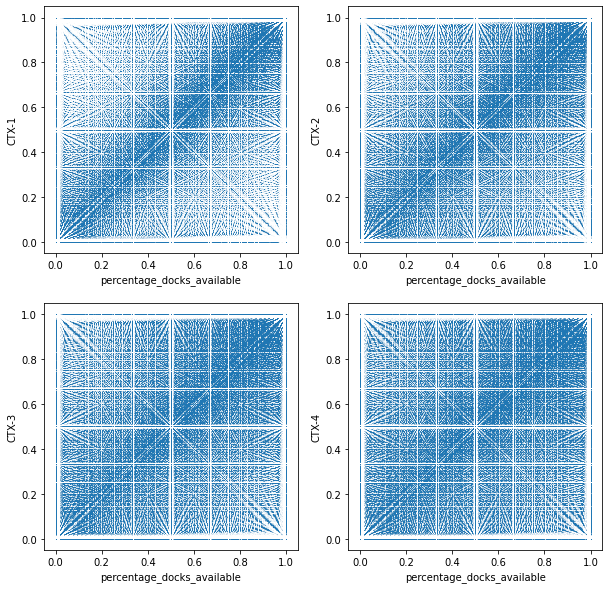

In [9]:
fig, ax = plt.subplots(2,2, figsize=(10, 10))


clean_data.plot(ax=ax[0][0], kind="scatter", x="percentage_docks_available", y="CTX-1",
             alpha=0.1, s=0.01)
clean_data.plot(ax=ax[0][1], kind="scatter", x="percentage_docks_available", y="CTX-2",
             alpha=0.1, s=0.01)
clean_data.plot(ax=ax[1][0], kind="scatter", x="percentage_docks_available", y="CTX-3",
             alpha=0.1, s=0.01)
clean_data.plot(ax=ax[1][1], kind="scatter", x="percentage_docks_available", y="CTX-4",
             alpha=0.1, s=0.01)

# plt.show()

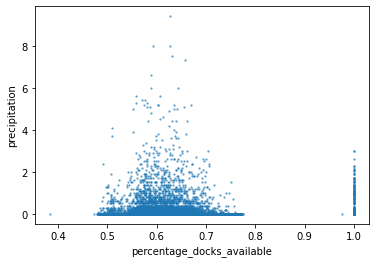

In [10]:
g = clean_data.groupby(['date', 'hour']).mean()

g.plot(kind="scatter", x="percentage_docks_available", y="precipitation",
             alpha=0.5, s=2)
plt.show()
# Se ve alguna correlación entre la cantidad de precipitacion y el % de docks disponibles 
# Siguiente mejora obtener el tiempo histórico por hora

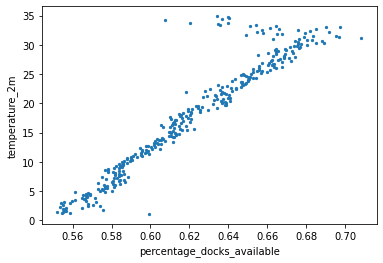

In [11]:
g = clean_data.groupby(['temperature_2m']).mean().reset_index()

g.plot(kind="scatter", x="percentage_docks_available", y="temperature_2m",
             alpha=1, s=5)
plt.show()

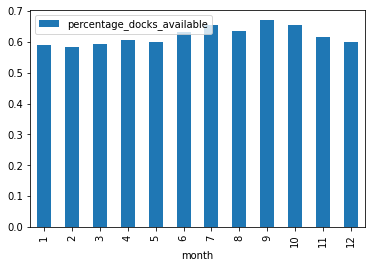

In [12]:
g=clean_data.groupby('month').mean().reset_index()
g.plot(kind="bar", x="month", y="percentage_docks_available")
plt.show()

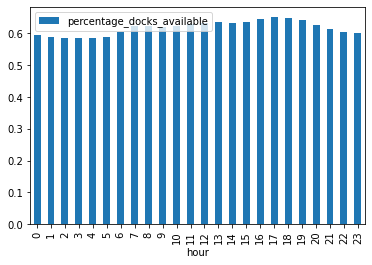

In [13]:
g=clean_data.groupby('hour').mean().reset_index()
g.plot(kind="bar", x="hour", y="percentage_docks_available")
plt.show()

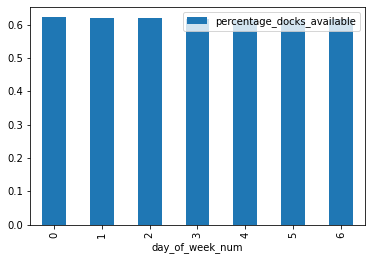

In [14]:
g=clean_data
g['date'] = pd.to_datetime(g['date'])
g['day_of_week_num'] = g['date'].dt.dayofweek
g = g.groupby('day_of_week_num').mean().reset_index()
g.plot(kind="bar", x="day_of_week_num", y="percentage_docks_available")
plt.show()

##### Charts for a certain station (DIAGONAL)

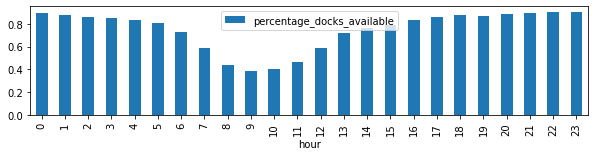

In [29]:
g=clean_data[clean_data['station_id']==305].groupby('hour').mean().reset_index()
g.plot(kind="bar", x="hour", y="percentage_docks_available", figsize=(10,2))
plt.show()

/Users/fernadavo/.virtualenvs/dev_new/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/fernadavo/.virtualenvs/dev_new/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


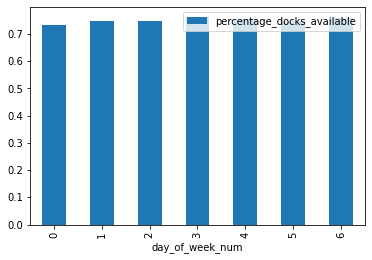

In [16]:
g=clean_data[clean_data['station_id']==305]
g['date'] = pd.to_datetime(g['date'])
g['day_of_week_num'] = g['date'].dt.dayofweek
g = g.groupby('day_of_week_num').mean().reset_index()
g.plot(kind="bar", x="day_of_week_num", y="percentage_docks_available")
plt.show()

In [17]:
clean_data.columns

Index(['station_id', 'lat', 'lon', 'altitude', 'capacity', 'precipitation',
       'temperature_2m', 'date', 'month', 'day', 'hour', 'CTX-1', 'CTX-2',
       'CTX-3', 'CTX-4', 'percentage_docks_available', 'day_of_week_num'],
      dtype='object')

In [23]:
# !pip install seaborn

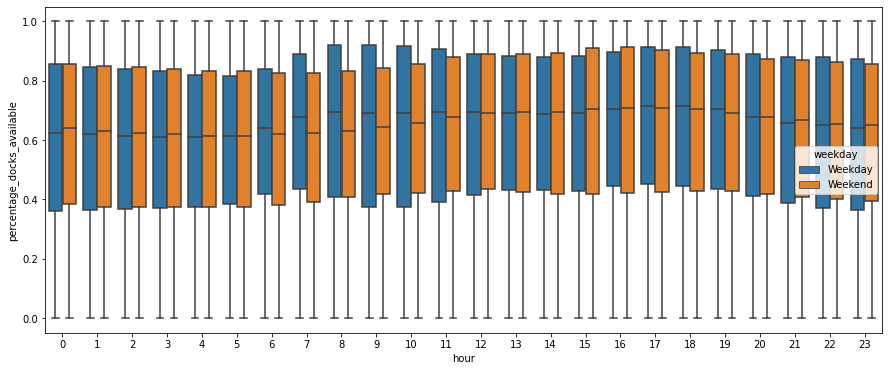

In [24]:
import seaborn as sns

g=clean_data
g['date'] = pd.to_datetime(g['date'])
g['day_of_week_num'] = g['date'].dt.dayofweek
g['weekday'] = g['day_of_week_num'].apply(lambda x: 'Weekend' if x in [5,6] else 'Weekday')


f, axes = plt.subplots(1, 1, figsize=(15, 6))
sns.boxplot(data=g, y='percentage_docks_available', x='hour', hue='weekday', ax=axes)


plt.show()

In [30]:
clean_data.groupby('station_id').mean().sort_values(by='altitude', ascending=False).head(5)

,lat,lon,altitude,capacity,precipitation,temperature_2m,month,day,hour,CTX-1,CTX-2,CTX-3,CTX-4,percentage_docks_available,day_of_week_num
station_id,,,,,,,,,,,,,,,
493,41.419965,2.140182,166.0,24.0,0.057428,17.061731,6.584807,15.848962,11.534744,0.807466,0.807430,0.807392,0.807358,0.807496,2.984095
490,41.428067,2.144378,150.0,50.0,0.054310,16.297983,6.398643,15.831798,11.538751,0.652537,0.652538,0.652539,0.652541,0.652548,2.992575
498,41.414497,2.140243,145.0,26.0,0.057752,16.998667,6.597251,15.768738,11.544574,0.872916,0.872923,0.872931,0.872931,0.872914,2.985518
488,41.434786,2.147904,132.0,27.0,0.057492,17.150168,6.523427,15.835915,11.538993,0.840462,0.840450,0.840437,0.840446,0.840474,2.991618
499,41.416056,2.142150,127.0,27.0,0.057468,16.694374,6.567166,15.814402,11.537798,0.823543,0.823511,0.823481,0.823468,0.823559,2.985786


In [31]:
clean_data.groupby('station_id').mean().sort_values(by='altitude', ascending=True).head(5)

,lat,lon,altitude,capacity,precipitation,temperature_2m,month,day,hour,CTX-1,CTX-2,CTX-3,CTX-4,percentage_docks_available,day_of_week_num
station_id,,,,,,,,,,,,,,,
339,41.401708,2.205380,2.0,27.0,0.060670,16.777848,6.218160,15.726695,11.535277,0.446479,0.446501,0.446469,0.446426,0.446479,2.991266
154,41.402628,2.201769,2.0,32.0,0.060571,16.781070,6.218122,15.727158,11.535332,0.491521,0.491526,0.491528,0.491533,0.491536,2.990333
377,41.377629,2.183689,2.0,29.0,0.060467,16.783841,6.220134,15.726122,11.538054,0.513495,0.513498,0.513501,0.513505,0.513493,2.989395
428,41.398390,2.196080,3.0,26.0,0.060253,16.787407,6.221809,15.728431,11.542994,0.558449,0.558461,0.558480,0.558503,0.558440,2.991304
165,41.399217,2.204141,3.0,27.0,0.060744,16.777123,6.215502,15.722535,11.533795,0.317965,0.318017,0.318068,0.318108,0.317929,2.989577


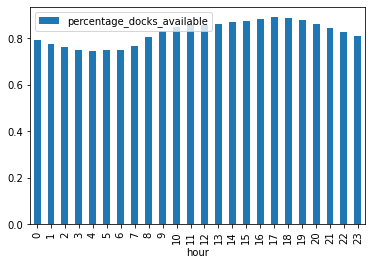

In [32]:
g=clean_data[clean_data['station_id']==499].groupby('hour').mean().reset_index()
g.plot(kind="bar", x="hour", y="percentage_docks_available")
plt.show()

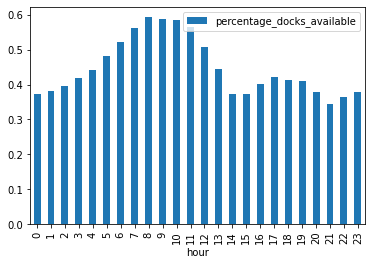

In [33]:
g=clean_data[clean_data['station_id']==339].groupby('hour').mean().reset_index()
g.plot(kind="bar", x="hour", y="percentage_docks_available")
plt.show()


##### Identify COVID Years

In [ ]:
g=clean_data[clean_data['station_id']==245].copy()
g['year_month'] = g['date'].apply(lambda x: str(x).split("-")[0]+str(x).split("-")[1])

g = g.groupby(['year_month']).mean().reset_index()
g.plot(kind="bar", x="year_month", y="percentage_docks_available")
plt.show()

##### Occupation map

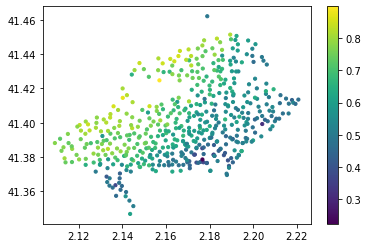

In [68]:
g = clean_data.groupby('station_id').mean().reset_index()

plt.scatter(g['lon'], g['lat'], c=g['percentage_docks_available'], s=10, cmap='viridis')
plt.colorbar()


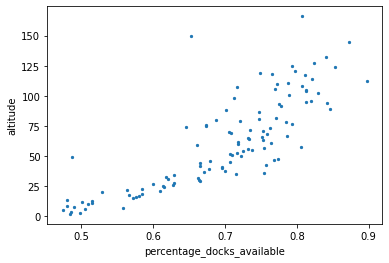

In [35]:
g = clean_data.groupby(['altitude']).mean().reset_index()

g.plot(kind="scatter", x="percentage_docks_available", y="altitude",
             alpha=1, s=5)
plt.show()

In [36]:
## Capacity

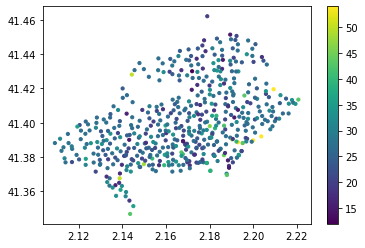

In [37]:
g = clean_data.groupby('station_id').mean().reset_index()

plt.scatter(g['lon'], g['lat'], c=g['capacity'], s=10, cmap='viridis')
plt.colorbar()

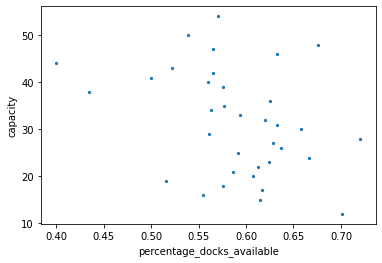

In [38]:
g = clean_data.groupby(['capacity']).mean().reset_index()

g.plot(kind="scatter", x="percentage_docks_available", y="capacity",
             alpha=1, s=5)
plt.show()

In [93]:
g = clean_data.groupby(['is_charging_station']).mean().reset_index()

g.plot(kind="scatter", x="is_charging_station", y="percentage_docks_available",
             alpha=1, s=5)
plt.show()

KeyboardInterrupt: 

#### Detect where to put more bikes or more docks

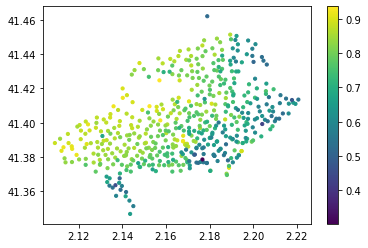

In [66]:
g = clean_data.groupby(['station_id', 'hour']).mean().reset_index()
g = g.groupby(['station_id']).max().reset_index()

g = g.sort_values(by='percentage_docks_available', ascending=False)
plt.scatter(g['lon'], g['lat'], c=g['percentage_docks_available'], s=10, cmap='viridis')
plt.colorbar()


In [60]:
g.sort_values(by='percentage_docks_available', ascending=False)

,station_id,hour,lat,lon,altitude,capacity,precipitation,temperature_2m,month,day,CTX-1,CTX-2,CTX-3,CTX-4,percentage_docks_available,day_of_week_num
507,518,23,41.424689,2.157049,112.0,27.0,0.075449,20.295833,6.609162,16.156920,0.936577,0.936524,0.936764,0.935624,0.936571,3.004016
492,503,23,41.409593,2.152495,105.0,30.0,0.076682,19.806113,6.207807,16.156885,0.935043,0.935118,0.934933,0.934821,0.935080,3.012791
214,222,23,41.401330,2.157444,58.0,27.0,0.074799,19.927369,6.202277,15.989492,0.927319,0.927208,0.927407,0.927497,0.928657,3.009857
62,66,23,41.389322,2.167839,23.0,16.0,0.074317,20.057230,5.738776,16.096421,0.924834,0.924834,0.924124,0.924192,0.924389,3.011224
486,497,23,41.409549,2.136031,124.0,27.0,0.074458,20.406043,6.603314,16.177033,0.920869,0.920992,0.920609,0.920040,0.920728,3.003945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,55,23,41.381428,2.173286,8.0,19.0,0.073864,20.151518,6.236979,16.058773,0.486187,0.484386,0.484330,0.484736,0.484813,3.011414
152,157,23,41.413232,2.217765,4.0,33.0,0.074019,20.141760,6.230104,16.046729,0.477200,0.477322,0.478286,0.479169,0.477439,3.010490
172,179,23,41.363520,2.136902,9.0,16.0,0.073680,20.154617,6.253913,16.077711,0.449907,0.450502,0.450061,0.450719,0.449688,3.008780
160,165,23,41.399217,2.204141,3.0,27.0,0.074761,20.136207,6.232297,16.033135,0.431007,0.430635,0.429958,0.430005,0.430427,3.008726


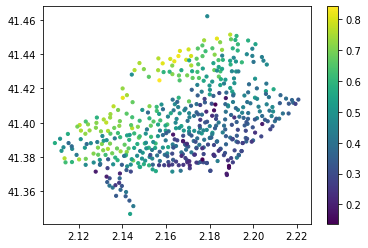

In [61]:
g = clean_data.groupby(['station_id', 'hour']).mean().reset_index()
g = g.groupby(['station_id']).min().reset_index()

g = g.sort_values(by='percentage_docks_available', ascending=False)

plt.scatter(g['lon'], g['lat'], c=g['percentage_docks_available'], s=10, cmap='viridis')
plt.colorbar()

In [62]:
g.sort_values(by='percentage_docks_available', ascending=True)

,station_id,hour,lat,lon,altitude,capacity,precipitation,temperature_2m,month,day,CTX-1,CTX-2,CTX-3,CTX-4,percentage_docks_available,day_of_week_num
444,455,0,41.410585,2.182683,27.0,22.0,0.039873,14.136871,6.396175,15.784868,0.137044,0.136951,0.137164,0.138420,0.137451,2.977355
370,378,0,41.378538,2.176743,5.0,21.0,0.040576,13.834859,6.182137,15.696916,0.138760,0.138894,0.138851,0.138729,0.138059,2.980836
29,31,0,41.374800,2.188905,4.0,18.0,0.040592,13.880685,6.201220,15.655536,0.152724,0.152968,0.153013,0.152969,0.152569,2.978392
24,26,0,41.407169,2.182072,22.0,18.0,0.037716,13.879738,6.193043,15.662882,0.164132,0.163841,0.164758,0.164853,0.164134,2.978392
30,32,0,41.373691,2.188928,4.0,15.0,0.039607,13.681458,6.527518,15.761163,0.171846,0.172023,0.171846,0.171347,0.171337,2.980473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470,481,0,41.435798,2.163872,89.0,27.0,0.039982,14.109909,6.395833,15.781818,0.811045,0.811208,0.811158,0.811285,0.811183,2.979335
452,463,0,41.449068,2.183380,68.0,24.0,0.040901,14.208550,6.473636,15.805195,0.812258,0.812459,0.812363,0.812171,0.811878,2.983471
487,498,0,41.414497,2.140243,145.0,26.0,0.037819,14.079920,6.572700,15.704253,0.812841,0.812992,0.812962,0.813539,0.812665,2.962709
462,473,0,41.438864,2.165751,94.0,31.0,0.037835,14.227824,6.494413,15.771296,0.828611,0.828612,0.828540,0.828495,0.828400,2.978782


In [71]:
info[info['station_id'].isin([518,503,222])].groupby('name').first().to_clipboard

<bound method NDFrame.to_clipboard of                    station_id physical_configuration        lat       lon  \
name                                                                        
C/ DEL CANÓ, 1            222    ELECTRICBIKESTATION  41.401330  2.157444   
C/ LLOBREGÓS, 115         518    ELECTRICBIKESTATION  41.424689  2.157049   
C/ MAIGNON, 31-41         503    ELECTRICBIKESTATION  41.409593  2.152495   

                   altitude            address  post_code  capacity  \
name                                                                  
C/ DEL CANÓ, 1           58     C/ DEL CANÓ, 1       8012        27   
C/ LLOBREGÓS, 115       112  C/ LLOBREGÓS, 115       8032        27   
C/ MAIGNON, 31-41       105  C/ MAIGNON, 31-41       8024        30   

                   nearby_distance cross_street  last_updated  ttl  \
name                                                                 
C/ DEL CANÓ, 1                1000         None    1648763987    8   
C/ LLOBREG

### Segment Data in Validation, Control and Test Groups

In [111]:
clean_data = pd.read_csv('clean_data_all_years.csv')

In [3]:
clean_data.columns

Index(['station_id', 'altitude', 'capacity', 'date', 'month', 'day', 'hour',
       'year', 'CTX-1', 'CTX-2', 'CTX-3', 'CTX-4',
       'percentage_docks_available', 'lat', 'lon', 'precipitation',
       'temperature_2m'],
      dtype='object')

In [3]:
from sklearn.model_selection import train_test_split

### Perform encodings on categorical columns
#### Finally we will only encode the stations with a target encoding at the beginning of each model

Al final no utilizé el one-hot-encoding en mes, dia y hora porque saldrían muchas columnas (se puede probar)

In [4]:
#!pip install category_encoders
import category_encoders as ce

X = clean_data.drop('percentage_docks_available', axis=1)  # Replace 'target_variable' with your actual target column name
y = clean_data[['percentage_docks_available']]
              
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_control, X_validation, y_control, y_validation = train_test_split(X_train_val, y_train_val, test_size=0.1/0.9, random_state=42)

target_encoder = ce.TargetEncoder(cols=['station_id'])
X_control['station_encoded'] = target_encoder.fit_transform(X_control['station_id'], y_control)

encoding_station_dict = X_control.groupby(['station_id', 'station_encoded']).mean().reset_index()\
[['station_id', 'station_encoded']].set_index('station_id')['station_encoded'].to_dict()

X_control = X_control[['station_encoded', 'precipitation', 'temperature_2m', 'altitude', 'capacity',
                         'month', 'day', 'hour','CTX-1', 'CTX-2', 'CTX-3', 'CTX-4']]

X_validation['station_encoded'] = X_validation['station_id'].map(encoding_station_dict)

X_validation = X_validation[['station_encoded', 'precipitation', 'temperature_2m', 'altitude', 'capacity',
                         'month', 'day','hour', 'CTX-1', 'CTX-2', 'CTX-3', 'CTX-4']]

X_test['station_encoded'] = X_test['station_id'].map(encoding_station_dict)

X_test = X_test[['station_encoded', 'precipitation', 'temperature_2m', 'altitude', 'capacity',
                         'month', 'day','hour', 'CTX-1', 'CTX-2', 'CTX-3', 'CTX-4']]

X_train_val['station_encoded'] = X_train_val['station_id'].map(encoding_station_dict)

X_train_val = X_train_val[['station_encoded', 'precipitation', 'temperature_2m', 'altitude', 'capacity',
                         'month', 'day','hour', 'CTX-1', 'CTX-2', 'CTX-3', 'CTX-4']]

/Users/ivanpujol/.virtualenvs/ndev/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/ivanpujol/.virtualenvs/ndev/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ivanpujol/.virtualenvs/ndev/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [5]:
#!pip install category_encoders
import category_encoders as ce

X = clean_data[~clean_data['year'].isin([2020])].drop('percentage_docks_available', axis=1)  # Replace 'target_variable' with your actual target column name
y = clean_data[~clean_data['year'].isin([2020])][['percentage_docks_available']]

X_train_val_no_20, X_test_no_20, y_train_val_no_20, y_test_no_20 = train_test_split(X, y, test_size=0.1, random_state=42)

X_control_no_20, X_validation_no_20, y_control_no_20, y_validation_no_20 = train_test_split(X_train_val_no_20, y_train_val_no_20, test_size=0.1/0.9, random_state=42)

target_encoder = ce.TargetEncoder(cols=['station_id'])
X_control_no_20['station_encoded'] = target_encoder.fit_transform(X_control_no_20['station_id'], y_control_no_20)

encoding_station_dict = X_control_no_20.groupby(['station_id', 'station_encoded']).mean().reset_index()\
[['station_id', 'station_encoded']].set_index('station_id')['station_encoded'].to_dict()

X_control_no_20 = X_control_no_20[['station_encoded', 'precipitation', 'temperature_2m', 'altitude', 'capacity',
                         'month', 'day', 'hour','CTX-1', 'CTX-2', 'CTX-3', 'CTX-4']]

X_validation_no_20['station_encoded'] = X_validation_no_20['station_id'].map(encoding_station_dict)

X_validation_no_20 = X_validation_no_20[['station_encoded', 'precipitation', 'temperature_2m', 'altitude', 'capacity',
                         'month', 'day','hour', 'CTX-1', 'CTX-2', 'CTX-3', 'CTX-4']]

X_test_no_20['station_encoded'] = X_test_no_20['station_id'].map(encoding_station_dict)

X_test_no_20 = X_test_no_20[['station_encoded', 'precipitation', 'temperature_2m', 'altitude', 'capacity',
                         'month', 'day','hour', 'CTX-1', 'CTX-2', 'CTX-3', 'CTX-4']]

X_train_val_no_20['station_encoded'] = X_train_val_no_20['station_id'].map(encoding_station_dict)

X_train_val_no_20 = X_train_val_no_20[['station_encoded', 'precipitation', 'temperature_2m', 'altitude', 'capacity',
                         'month', 'day','hour', 'CTX-1', 'CTX-2', 'CTX-3', 'CTX-4']]

/Users/ivanpujol/.virtualenvs/ndev/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/ivanpujol/.virtualenvs/ndev/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ivanpujol/.virtualenvs/ndev/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [114]:
#!pip install category_encoders
import category_encoders as ce

X_train_no_23 = clean_data[~clean_data['year'].isin([2023])].drop('percentage_docks_available', axis=1)
y_train_no_23 = clean_data[~clean_data['year'].isin([2023])][['percentage_docks_available']]

target_encoder = ce.TargetEncoder(cols=['station_id'])
X_train_no_23['station_encoded'] = target_encoder.fit_transform(X_train_no_23['station_id'], y_train_no_23)

encoding_station_dict_no_23 = X_train_no_23.groupby(['station_id', 'station_encoded']).mean().reset_index()\
[['station_id', 'station_encoded']].set_index('station_id')['station_encoded'].to_dict()


X_train_no_23=X_train_no_23[['station_encoded', 'precipitation', 'temperature_2m', 'altitude', 'capacity',
                         'month', 'day','hour', 'CTX-1', 'CTX-2', 'CTX-3', 'CTX-4']]


X_train_no_2023 = clean_data[~clean_data['year'].isin([2023,2020])].drop('percentage_docks_available', axis=1)
y_train_no_2023 = clean_data[~clean_data['year'].isin([2023,2020])][['percentage_docks_available']]

target_encoder = ce.TargetEncoder(cols=['station_id'])
X_train_no_2023['station_encoded'] = target_encoder.fit_transform(X_train_no_2023['station_id'], y_train_no_2023)

encoding_station_dict_no_2023 = X_train_no_2023.groupby(['station_id', 'station_encoded']).mean().reset_index()\
[['station_id', 'station_encoded']].set_index('station_id')['station_encoded'].to_dict()

X_train_no_2023=X_train_no_2023[['station_encoded', 'precipitation', 'temperature_2m', 'altitude', 'capacity',
                         'month', 'day','hour', 'CTX-1', 'CTX-2', 'CTX-3', 'CTX-4']]

#X_train_no_2023, X_validation_no_2023, y_train_no_2023, y_validation_no_2023  = train_test_split(X_train_no_2023,y_train_no_2023, test_size=0.1, random_state=42)


X_test_23 = clean_data[clean_data['year'].isin([2023])].drop('percentage_docks_available', axis=1)

X_test_23['station_encoded'] = X_test_23['station_id'].map(encoding_station_dict_no_23)

X_test_23 = X_test_23[['station_encoded', 'precipitation', 'temperature_2m', 'altitude', 'capacity',
                         'month', 'day','hour', 'CTX-1', 'CTX-2', 'CTX-3', 'CTX-4']]

y_test_23 = clean_data[clean_data['year'].isin([2023])][['percentage_docks_available']]

### Train Models

#### Linear Regression

In [7]:
# !pip install category_encoders

In [7]:
from sklearn.metrics import mean_squared_error

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import category_encoders as ce

linear_reg = []

# Create an instance of the LinearRegression model
linear_reg.append(LinearRegression())
linear_reg.append(LinearRegression())

# Fit the model to the data
linear_reg[0].fit(X_control, y_control)
linear_reg[1].fit(X_control_no_20,y_control_no_20)

# Print the coefficients and intercept
print("Intercept:", linear_reg[0].intercept_)
print("Coefficients:", linear_reg[0].coef_)
print("Intercept:", linear_reg[1].intercept_)
print("Coefficients:", linear_reg[1].coef_)
print("Columns:", X_control.columns)
## El coeficiente de las precipitaciones es muy bajo, habrá que meter precipitación por hora
## Pedir a ChatGPT fuente de datos históricos de precipitacion por hora en BCN

Intercept: [-0.0113916]
Coefficients: [[ 1.68082133e-01 -1.18421510e-04  5.49622660e-04  5.71370837e-07
   3.48227457e-06  4.40683823e-04 -2.10869611e-05 -6.85488074e-05
   8.48591220e-01  9.68417064e-03 -8.48775285e-04 -2.53235440e-02]]
Intercept: [-0.01119894]
Coefficients: [[ 1.70845826e-01 -9.41923413e-04  5.95992291e-04  2.22723908e-06
   1.59919101e-06  3.09299093e-04 -8.61248349e-06 -7.16720442e-05
   8.47793385e-01  8.93224391e-03 -3.26031677e-05 -2.77104196e-02]]
Columns: Index(['station_encoded', 'precipitation', 'temperature_2m', 'altitude',
       'capacity', 'month', 'day', 'hour', 'CTX-1', 'CTX-2', 'CTX-3', 'CTX-4'],
      dtype='object')


In [9]:
# Make predictions on the test data
linear_reg_pred = []
s = []
mse = []
desv = []

s.append(linear_reg[0].score(X_control,y_control))
s.append(linear_reg[1].score(X_control_no_20,y_control_no_20))

# Make predictions on the validation data

linear_reg_pred.append(linear_reg[0].predict(X_validation))
linear_reg_pred.append(linear_reg[1].predict(X_validation_no_20))

# Calculate the mean squared error (MSE) to evaluate the model's performance and its interval under 95% confidence level.

mse.append(mean_squared_error(y_validation, linear_reg_pred[0]))
mse.append(mean_squared_error(y_validation_no_20, linear_reg_pred[1]))

desv.append(((y_validation[['percentage_docks_available']]-linear_reg_pred[0])*(y_validation[['percentage_docks_available']]-linear_reg_pred[0])).percentage_docks_available.std())
desv.append(((y_validation_no_20[['percentage_docks_available']]-linear_reg_pred[1])*(y_validation_no_20[['percentage_docks_available']]-linear_reg_pred[1])).percentage_docks_available.std())

print("Correlation Coefficient (R^2) is:",s[0],s[1])
print("MSE:", mse[0],mse[1])
print("MSE STD:",desv[0],desv[1])
print("Under 95% confidence level, the error is:",mse[0]+1.96*desv[0],mse[1]+1.96*desv[1])

Correlation Coefficient (R^2) is: 0.7631244147820245 0.7613905997865595
MSE: 0.021575298778074462 0.021805757163070334
MSE STD: 0.06234707182950362 0.06237566840163322
Under 95% confidence level, the error is: 0.14377555956390156 0.14406206723027146


In [115]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import category_encoders as ce

linear_reg = []

# Create an instance of the LinearRegression model
linear_reg.append(LinearRegression())
linear_reg.append(LinearRegression())

# Fit the model to the data
linear_reg[0].fit(X_train_no_23, y_train_no_23)
linear_reg[1].fit(X_train_no_2023,y_train_no_2023)

# Print the coefficients and intercept
print("Intercept:", linear_reg[0].intercept_)
print("Coefficients:", linear_reg[0].coef_)
print("Intercept:", linear_reg[1].intercept_)
print("Coefficients:", linear_reg[1].coef_)
print("Columns:", X_train_no_23.columns)
## El coeficiente de las precipitaciones es muy bajo, habrá que meter precipitación por hora
## Pedir a ChatGPT fuente de datos históricos de precipitacion por hora en BCN

Intercept: [-0.0118362]
Coefficients: [[ 1.67968971e-01 -9.17754404e-05  5.53054841e-04  8.33723347e-08
   2.00824490e-06  4.54722499e-04 -2.31150702e-05 -6.42628890e-05
   8.49270478e-01  9.04648726e-03 -7.71144394e-04 -2.55191903e-02]]
Intercept: [-0.01192564]
Coefficients: [[ 1.71129550e-01 -9.79586254e-04  6.05795945e-04  2.46845057e-06
  -1.40477617e-06  3.16914730e-04 -1.22022322e-05 -6.01092093e-05
   8.48049130e-01  9.12876816e-03 -5.63965009e-04 -2.79252051e-02]]
Columns: Index(['station_encoded', 'precipitation', 'temperature_2m', 'altitude',
       'capacity', 'month', 'day', 'hour', 'CTX-1', 'CTX-2', 'CTX-3', 'CTX-4'],
      dtype='object')


In [116]:
# Make predictions on the test data
linear_reg_pred = []
s = []
mse = []
desv = []

s.append(linear_reg[0].score(X_train_no_23,y_train_no_23))
s.append(linear_reg[1].score(X_train_no_2023,y_train_no_2023))

# Make predictions on the validation data

linear_reg_pred.append(linear_reg[0].predict(X_test_23))
linear_reg_pred.append(linear_reg[1].predict(X_test_23))

# Calculate the mean squared error (MSE) to evaluate the model's performance and its interval under 95% confidence level.

mse.append(mean_squared_error(y_test_23, linear_reg_pred[0]))
mse.append(mean_squared_error(y_test_23, linear_reg_pred[1]))

desv.append(((y_test_23[['percentage_docks_available']]-linear_reg_pred[0])*(y_test_23[['percentage_docks_available']]-linear_reg_pred[0])).percentage_docks_available.std())
desv.append(((y_test_23[['percentage_docks_available']]-linear_reg_pred[1])*(y_test_23[['percentage_docks_available']]-linear_reg_pred[1])).percentage_docks_available.std())

print("Correlation Coefficient (R^2) is:",s[0],s[1])
print("MSE:", mse[0],mse[1])
print("MSE STD:",desv[0],desv[1])
print("Under 95% confidence level, the error is:",mse[0]+1.96*desv[0],mse[1]+1.96*desv[1])

Correlation Coefficient (R^2) is: 0.7658939650455575 0.764908768125711
MSE: 0.021217355053751847 0.021219411620520344
MSE STD: 0.05789125397248528 0.05778703902871333
Under 95% confidence level, the error is: 0.13468421283982301 0.13448200811679847


In [102]:
mse

[0.021174939371356064, 0.02118313278543649]

In [76]:
mean_squared_error(y_validation_no_2023, linear_reg_pred[1])

0.022186813240409428

#### Random forest

In [54]:
from sklearn.ensemble import RandomForestRegressor

a = []
b = []
c = []
d = []
rf_model = []
y_pred = []
mse = []

rf_model.append(RandomForestRegressor(n_estimators=50,random_state=42,verbose=10,n_jobs=-1))
rf_model.append(RandomForestRegressor(n_estimators=100,random_state=42,verbose=10,n_jobs=-1))
#rf_model.append(RandomForestRegressor(n_estimators=150,random_state=42))

rf_model[0].fit(X_train_no_2023, y_train_no_2023)
rf_model[1].fit(X_train_no_2023, y_train_no_2023)
#rf_model[2].fit(X_train_no_2023, y_train_no_2023)

y_pred.append(rf_model[0].predict(X_validation_23))
y_pred.append(rf_model[1].predict(X_validation_23))
#y_pred.append(rf_model[2].predict(X_validation_23))

/Users/ivanpujol/.virtualenvs/ndev/lib/python3.7/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 50building tree 2 of 50
building tree 3 of 50

building tree 4 of 50building tree 5 of 50

building tree 6 of 50building tree 7 of 50
building tree 8 of 50



KeyboardInterrupt: 

In [15]:
from sklearn.metrics import mean_squared_error
mse = []
desv = []

mse.append(mean_squared_error(y_validation_23, y_pred[0]))
mse.append(mean_squared_error(y_validation_23, y_pred[1]))
#mse.append(mean_squared_error(y_validation_23, y_pred[2]))
desv.append(((y_validation_23.percentage_docks_available-y_pred[0])*(y_validation_23.percentage_docks_available-y_pred[0])).std())
desv.append(((y_validation_23.percentage_docks_available-y_pred[1])*(y_validation_23.percentage_docks_available-y_pred[1])).std())
#desv.append(((y_validation_23.percentage_docks_available-y_pred[2])*(y_validation_23.percentage_docks_available-y_pred[2])).std())
a.append(mse)
b.append(desv)
print(a,b)

[[0.021123218769531972, 0.021124363957665006]] [[0.057030161220752586, 0.05702274737159495]]


In [24]:
rf_model.append(RandomForestRegressor(n_estimators=150,max_depth=7,random_state=42,verbose=10))

In [26]:
rf_model[6].fit(X_train_no_2023, y_train_no_2023)
#y_pred.append(rf_model[3].prTedict(X_validation_23))

/Users/ivanpujol/.virtualenvs/ndev/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 150


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.1s remaining:    0.0s


building tree 2 of 150


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   54.0s remaining:    0.0s


building tree 3 of 150


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s


building tree 4 of 150


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.8min remaining:    0.0s


building tree 5 of 150


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.2min remaining:    0.0s


building tree 6 of 150


KeyboardInterrupt: 

In [ ]:
mse.append(mean_squared_error(y_validation_23, y_pred[3]))
desv.append(((y_validation_23.percentage_docks_available-y_pred[3])*(y_validation_23.percentage_docks_available-y_pred[3])).std())

In [1]:
# 43 seconds 50K rows -> Complete dataset in ~34 minutes
len(X_control)

NameError: name 'X_control' is not defined

#### Support Vector Machine

In [ ]:
from sklearn.svm import SVR

# Train the Support Vector Machines (SVM) model
svm_model = SVR()
svm_model.fit(X_control_no_2023.head(20000), y_control.no_2023.head(20000))

In [ ]:
#Calculate Correlation Coefficient

s = svm_model.score(X_train_no_2023.head(20000), y_train_no_2023.head(20000))

# Make predictions on the validation data

y_pred = svm_model.predict(X_validation_23)

# Calculate the mean squared error (MSE) to evaluate the model's performance and its interval under 95% confidence level.

mse = mean_squared_error(y_validation_23, y_pred)
desv = ((y_validation_23.percentage_docks_available-y_pred)*(y_validation_23.percentage_docks_available-y_pred)).std()

print("Correlation Coefficient (R^2) is:",s)
print("MSE:", mse)
print("MSE STD:",desv)
print("Under 95% confidence level, the MSE is within the interval:",mse+1.96*desv)

In [ ]:
# 8 seconds 1K rows -> Complete dataset in ~5.4 hours (not manageble)
len(X_control)

In [35]:
from sklearn.preprocessing import StandardScaler

#### Simple neural network

In [46]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


# Scale the input features
scaler = StandardScaler()
X_control_scaled_no_23 = scaler.fit_transform(X_train_no_23)
X_control_scaled_no_2023 = scaler.fit_transform(X_train_no_2023)

X_validation_scaled_23 = scaler.transform(X_validation_23)

In [55]:
X_train_no_2023

,station_encoded,precipitation,temperature_2m,altitude,capacity,month,day,hour,CTX-1,CTX-2,CTX-3,CTX-4
0,0.585211,0.0,10.5,16.0,46.0,3,28,21,0.200000,0.466667,0.400000,0.466667
1,0.585211,0.0,9.0,16.0,46.0,3,28,22,0.000000,0.200000,0.466667,0.400000
2,0.585211,0.0,8.8,16.0,46.0,3,28,23,0.066667,0.000000,0.200000,0.466667
3,0.585211,0.0,8.5,16.0,46.0,3,29,0,0.000000,0.066667,0.000000,0.200000
4,0.585211,0.0,8.1,16.0,46.0,3,29,1,0.000000,0.000000,0.066667,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
15770367,0.780472,0.0,11.7,110.0,24.0,12,31,21,0.708333,0.833333,0.916667,0.916667
15770368,0.780472,0.0,10.6,110.0,24.0,12,31,22,0.625000,0.708333,0.833333,0.916667
15770369,0.780472,0.0,10.6,110.0,24.0,12,31,22,0.541667,0.625000,0.708333,0.833333
15770370,0.780472,0.0,9.5,110.0,24.0,12,31,23,0.583333,0.541667,0.625000,0.708333


In [48]:
NN = []

NN.append(Sequential())
NN.append(Sequential())

NN[0].add(Dense(64, activation='relu', input_shape=(X_control_scaled_no_23.shape[1],)))
NN[1].add(Dense(64, activation='relu', input_shape=(X_control_scaled_no_2023.shape[1],)))

NN[0].add(Dense(1, activation='linear'))
NN[1].add(Dense(1, activation='linear'))

NN[0].compile(loss='mean_squared_error', optimizer=Adam())
NN[1].compile(loss='mean_squared_error', optimizer=Adam())

NN[0].fit(X_control_scaled_no_23, np.array(y_train_no_23.head(1000)), epochs=1, batch_size=32, verbose=1)
NN[1].fit(X_control_scaled_no_2023, np.array(y_train_no_2023.head(1000)), epochs=1, batch_size=32, verbose=1)

32/32 [==============================] - 0s 2ms/step - loss: 0.0695


In [52]:
#s.append(NN[0].score(X_control_scaled_no_23,y_train_no_23))
#s.append(NN[1].score(X_control_scaled_no_2023,y_train_no_2023))

X_validation_scaled_23 = scaler.transform(X_validation_23)
# Make predictions on the validation data
NN_pred = []
mse = []
desv = []

NN_pred.append(NN[0].predict(X_validation_scaled_23))
NN_pred.append(NN[1].predict(X_validation_scaled_23))

# Calculate the mean squared error (MSE) to evaluate the model's performance and its interval under 95% confidence level.

mse.append(mean_squared_error(np.array(y_validation_23), NN_pred[0]))
mse.append(mean_squared_error(np.array(y_validation_23), NN_pred[1]))

desv.append(((y_validation_23[['percentage_docks_available']]-NN_pred[0])*(y_validation_23[['percentage_docks_available']]-NN_pred[0])).percentage_docks_available.std())
desv.append(((y_validation_23[['percentage_docks_available']]-NN_pred[1])*(y_validation_23[['percentage_docks_available']]-NN_pred[1])).percentage_docks_available.std())

print("Correlation Coefficient (R^2) is:",s[0],s[1])
print("MSE:", mse[0],mse[1])
print("MSE STD:",desv[0],desv[1])
print("Under 95% confidence level, the error is:",mse[0]+1.96*desv[0],mse[1]+1.96*desv[1])

32/32 [==============================] - 0s 1ms/step
MSE: 6.738135625814013 12.082918574360603
MSE STD: 6.340016297756087 26.75250562030755
Under 95% confidence level, the error is: 19.164567569415944 64.5178295901634


In [51]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Scale the input features
scaler = StandardScaler()
X_control_scaled_no_23 = scaler.fit_transform(X_train_no_23)

X_control_scaled_no_2023 = scaler.fit_transform(X_train_no_2023)

X_validation_scaled_23 = scaler.transform(X_validation_23)

NNN = []

for i in tqdm(range(0,1)):
    NNN.append(Sequential())
    NNN[i].add(Dense(64,input_shape=(X_control_scaled_no_2023.shape[1],)))
    for j in range(0,i):
        NNN[i].add(Dense(64/(j+1), activation='relu'))
    NNN[i].add(Dense(1, activation='sigmoid'))
    NNN[i].compile(loss='mean_squared_error', optimizer=Adam())
    NNN[i].fit(X_control_scaled_no_2023, np.array(y_train_no_2023), epochs=3, batch_size=32, verbose=1)

  0%|          | 0/1 [00:00<?, ?it/s]


IndexError: list index out of range

In [144]:
for i in tqdm(range(5,10)):
    NNN.append(Sequential())
    for j in range(0,i+1):
        NNN[i].add(Dense(64/(j+1), activation='relu', input_shape=(X_control_scaled_no_2023.shape[1],)))
    NNN[i].add(Dense(1, activation='sigmoid'))
    NNN[i].compile(loss='mean_squared_error', optimizer=Adam())
    NNN[i].fit(X_control_scaled_no_2023, np.array(y_train_no_2023), epochs=3, batch_size=32, verbose=1)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/3
339553/339553 [==============================] - 667s 2ms/step - loss: 0.0202
Epoch 2/3
339553/339553 [==============================] - 675s 2ms/step - loss: 0.0198
Epoch 3/3
339553/339553 [==============================] - 680s 2ms/step - loss: 0.0197


 20%|██        | 1/5 [33:45<2:15:00, 2025.12s/it]

Epoch 1/3
339553/339553 [==============================] - 577s 2ms/step - loss: 0.0201
Epoch 2/3
339553/339553 [==============================] - 584s 2ms/step - loss: 0.0197
Epoch 3/3
339553/339553 [==============================] - 585s 2ms/step - loss: 0.0196


 40%|████      | 2/5 [1:02:51<1:33:03, 1861.11s/it]

Epoch 1/3
339553/339553 [==============================] - 590s 2ms/step - loss: 0.0201
Epoch 2/3
339553/339553 [==============================] - 594s 2ms/step - loss: 0.0197
Epoch 3/3
339553/339553 [==============================] - 605s 2ms/step - loss: 0.0196


 60%|██████    | 3/5 [1:32:42<1:00:57, 1828.97s/it]

Epoch 1/3
339553/339553 [==============================] - 598s 2ms/step - loss: 0.0201
Epoch 2/3
339553/339553 [==============================] - 604s 2ms/step - loss: 0.0197
Epoch 3/3
339553/339553 [==============================] - 604s 2ms/step - loss: 0.0196


 80%|████████  | 4/5 [2:02:50<30:20, 1820.66s/it]  

Epoch 1/3
339553/339553 [==============================] - 605s 2ms/step - loss: 0.0201
Epoch 2/3
339553/339553 [==============================] - 608s 2ms/step - loss: 0.0197
Epoch 3/3
339553/339553 [==============================] - 610s 2ms/step - loss: 0.0196


100%|██████████| 5/5 [2:33:13<00:00, 1838.67s/it]


In [143]:
NNN_pred = []
mse = []
desv = []

X_validation_scaled_23 = scaler.transform(X_validation_23)

for i in tqdm(range(0,5)):
    NNN_pred.append(NNN[i].predict(X_validation_scaled_23))
    mse.append(mean_squared_error(np.array(y_validation_23),NNN_pred[i]))
    desv.append(((y_validation_23[['percentage_docks_available']]-NNN_pred[i])*(y_validation_23[['percentage_docks_available']]-NNN_pred[i])).percentage_docks_available.std())

print("MSE:", mse)
print("MSE STD:",desv)
#print("Under 95% confidence level, the error is:",mse+2*desv)

  0%|          | 0/5 [00:00<?, ?it/s]

20910/20910 [==============================] - 23s 1ms/step


 20%|██        | 1/5 [00:28<01:53, 28.35s/it]

20910/20910 [==============================] - 25s 1ms/step


 40%|████      | 2/5 [00:57<01:27, 29.04s/it]

20910/20910 [==============================] - 25s 1ms/step


 60%|██████    | 3/5 [01:27<00:58, 29.48s/it]

20910/20910 [==============================] - 25s 1ms/step


 80%|████████  | 4/5 [01:57<00:29, 29.63s/it]

20910/20910 [==============================] - 26s 1ms/step


100%|██████████| 5/5 [02:28<00:00, 29.64s/it]

MSE: [0.019603723044956597, 0.019297837915115572, 0.019108578633197416, 0.019055276096905487, 0.019091852482526598]
MSE STD: [0.052420569211507395, 0.05371747782656764, 0.05058249123966113, 0.052340100005496194, 0.05021551950727971]
Under 95% confidence level, the error is: [0.019603723044956597, 0.019297837915115572, 0.019108578633197416, 0.019055276096905487, 0.019091852482526598, 0.052420569211507395, 0.05371747782656764, 0.05058249123966113, 0.052340100005496194, 0.05021551950727971, 0.052420569211507395, 0.05371747782656764, 0.05058249123966113, 0.052340100005496194, 0.05021551950727971]


In [95]:
weather_data.date

0        2019-01-01
1        2019-01-01
2        2019-01-01
3        2019-01-01
4        2019-01-01
            ...    
38683    2023-05-31
38684    2023-05-31
38685    2023-05-31
38686    2023-05-31
38687    2023-05-31
Name: date, Length: 38688, dtype: object

In [83]:
test = pd.read_csv('metadata_sample_submission.csv')
test= test.merge(info,on='station_id',how='left')
test['station_encoded'] = test['station_id'].map(encoding_station_dict_no_2023)
test['year']='2023'
test['date'] = pd.to_datetime(test[['year','month', 'day']])
test['date']=test['date'].astype(str)
test = test.merge(weather_data[['date','hour', 'precipitation', 'temperature_2m']] ,on=['date','hour'], how='left')
test = test.rename(columns={'ctx-1': 'CTX-1', 'ctx-2': 'CTX-2','ctx-3':'CTX-3','ctx-4':'CTX-4'})
test=test[['station_encoded', 'precipitation', 'temperature_2m', 'altitude',
      'capacity', 'month', 'day', 'hour', 'CTX-1', 'CTX-2', 'CTX-3', 'CTX-4']]

test_scaled_kaggle = scaler.transform(test)


In [140]:
aux = NNN[5].predict(test_scaled_kaggle)

1719/1719 [==============================] - 3s 2ms/step


In [86]:
aux_2 = rf_model[2].predict(test)

IndexError: list index out of range

In [106]:
aux_3 = linear_reg[1].predict(test)

In [44]:
aux_3

array([[0.78734415],
       [0.642064  ],
       [0.59838806],
       ...,
       [0.71231571],
       [0.49692326],
       [0.73434145]])

In [108]:
pd.DataFrame(aux_3,columns=['percentage_docks_available']).to_csv('kaggle_test_5_lreg.csv')

In [83]:
test.merge()

Index(['index', 'station_id', 'month', 'day', 'hour', 'ctx-4', 'ctx-3',
       'ctx-2', 'ctx-1'],
      dtype='object')

In [89]:
X_validation_23.columns

Index(['station_encoded', 'precipitation', 'temperature_2m', 'altitude',
       'capacity', 'month', 'day', 'hour', 'CTX-1', 'CTX-2', 'CTX-3', 'CTX-4'],
      dtype='object')

In [36]:
np.array(y_validation_23.head(1000)).shape

(1000, 1)

#### Cross Validation

In [34]:
from sklearn.model_selection import cross_val_score


models = [
    rf_model,
    linear_reg,
    svm_model,
#     NN
]

# Perform cross-validation
for model in models:
    # Perform cross-validation on the model
    scores = cross_val_score(model, X_control.head(100000), y_control.head(100000),
                             cv=5, scoring='neg_mean_squared_error')
    
    # Convert the negative MSE scores to positive
    scores = -scores
    
    # Calculate the mean and standard deviation of the scores
    mean_score = scores.mean()
    std_score = scores.std()
    
    # Print the model's performance metrics
    print(f"Model: {type(model).__name__}")
    print("Cross-Validation Scores:", scores)
    print("Mean MSE:", mean_score)
    print("Standard Deviation of MSE:", std_score)
    print()

Model: RandomForestRegressor
Cross-Validation Scores: [0.02137131 0.02185079 0.02146338]
Mean MSE: 0.02156182496240534
Standard Deviation of MSE: 0.00020775444261539666

Model: LinearRegression
Cross-Validation Scores: [0.02131222 0.02196865 0.02168128]
Mean MSE: 0.021654050726479995
Standard Deviation of MSE: 0.00026867663433255293

Model: SVR
Cross-Validation Scores: [0.0215479  0.02212105 0.02185163]
Mean MSE: 0.021840196527920682
Standard Deviation of MSE: 0.00023412651816526813



In [46]:
# from sklearn.model_selection import KFold

# # Initialize lists to store the MSE scores for each fold
# mse_scores = []

# # Create the K-Fold cross-validation object
# kf = KFold(n_splits=3, shuffle=True)

# # Perform cross-validation
# for train_index, val_index in kf.split(X_control.to_numpy()):
#     # Split the data into training and validation sets for the current fold
#     X_train, X_val = X_control.to_numpy()[train_index], X_control.to_numpy()[val_index]
#     y_train, y_val = y_control[train_index], y_control[val_index]
    
#     # Create a new instance of the neural network model
#     model = NN
    
#     # Train the model on the training data for the current fold
#     model.fit(X_train, y_train, epochs=3, batch_size=32, verbose=0)
    
#     # Make predictions on the validation set
#     y_pred = model.predict(X_val)
    
#     # Calculate the mean squared error for the fold
#     mse = mean_squared_error(y_val, y_pred)
    
#     # Append the MSE score to the list
#     mse_scores.append(mse)

# # Calculate the mean and standard deviation of the MSE scores
# mean_mse = np.mean(mse_scores)
# std_mse = np.std(mse_scores)

# # Print the cross-validation results
# print("Cross-Validation MSE Scores:", mse_scores)
# print("Mean MSE:", mean_mse)
# print("Standard Deviation of MSE:", std_mse)

In [ ]:
# data[(data['is_renting']==0)]

In [21]:
# data[data['num_bikes_available']!=(data['num_bikes_available_types.mechanical']+data['num_bikes_available_types.ebike'])]

In [ ]:
# import matplotlib.pyplot as plt
